## Land Cover Classification of Satellite HSI Imagery using CNN

In [123]:
import numpy as np
import pandas as pd
import earthpy.plot as ep
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

from scipy.io import loadmat

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Load data:

In [124]:
data = loadmat('Salinas_corrected.mat')['salinas_corrected']     #figures
gt = loadmat('Salinas_gt.mat')['salinas_gt']                     #ground truth
print('Data Shape:',data.shape[:-1])
print('Number of Bands:',data.shape[-1])

Data Shape: (512, 217)
Number of Bands: 204


### DataFrame:

In [125]:
df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1)) #reshape (512*217)
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]      #rename columns
df['class'] = gt.ravel()                                         #concatenate classes
df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band196,band197,band198,band199,band200,band201,band202,band203,band204,class
0,290,381,585,1041,1316,1397,1319,1462,1643,1683,...,96,109,93,54,79,54,36,11,17,0
1,290,381,519,1041,1316,1352,1319,1462,1643,1683,...,94,111,96,56,83,56,36,11,15,0
2,290,381,585,1041,1286,1352,1300,1412,1614,1644,...,88,107,89,54,81,54,30,11,11,0
3,290,381,585,999,1316,1374,1280,1380,1584,1631,...,86,105,85,56,75,50,30,11,19,0
4,219,381,585,999,1286,1352,1261,1396,1555,1618,...,83,105,83,48,75,50,24,9,17,0


In [126]:
df['class'].astype('category').describe()   #describe classes

count     111104
unique        17
top            0
freq       56975
Name: class, dtype: int64

### Data Visualization:

Fig. RGB:


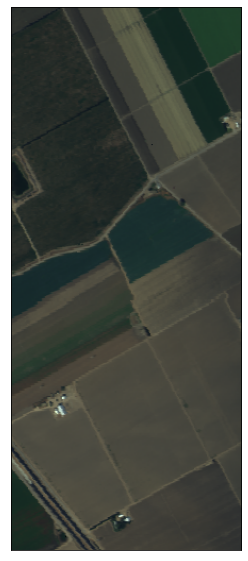

In [127]:
mdata = np.moveaxis(data, -1, 0)

print('Fig. RGB:')
ep.plot_rgb(mdata, (29, 19, 9)) 
plt.show()

Fig. HSI:


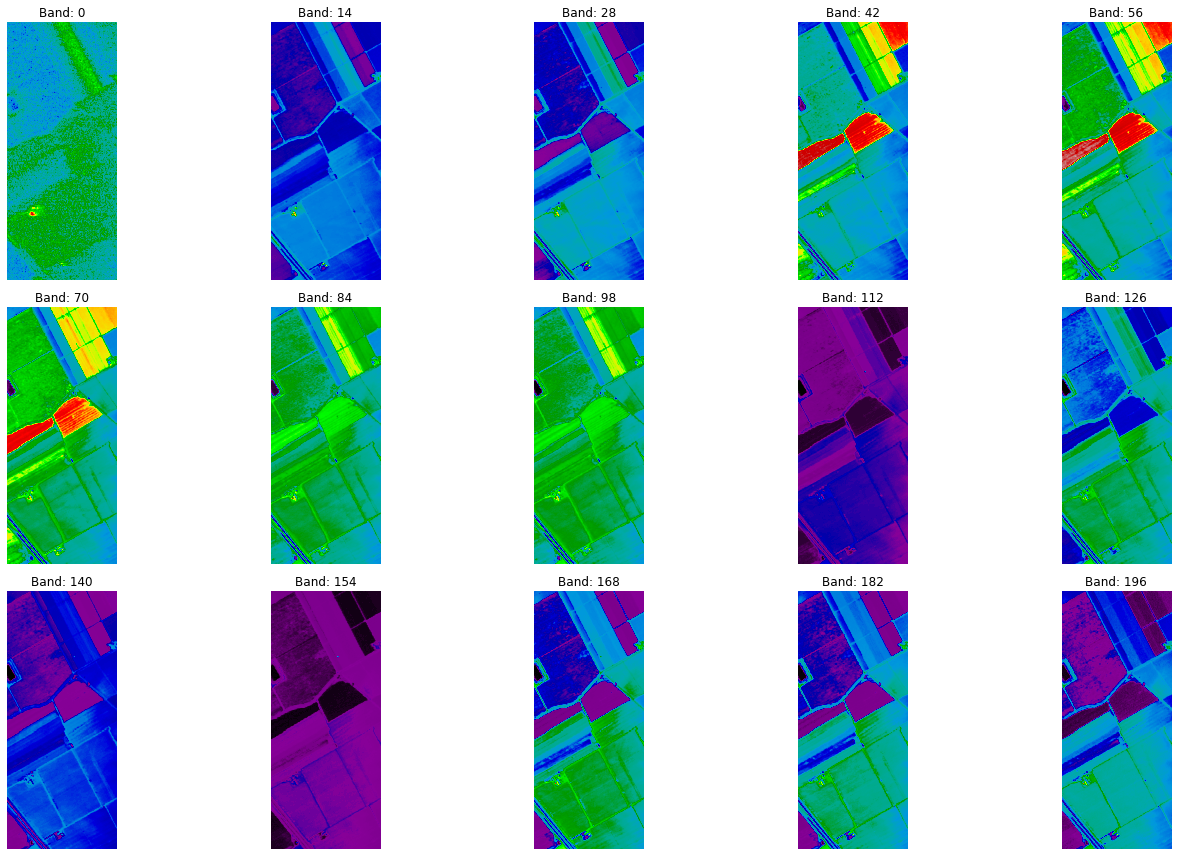

In [128]:
fig = plt.figure(figsize = (20, 12))
subfig = fig.subplots(3, 5)

n = 0
for i in range(3):
  for j in range(5):    
    subfig[i][j].imshow(data[:, :, n], cmap='nipy_spectral')
    subfig[i][j].axis('off')
    subfig[i][j].title.set_text("Band: "+str(n))
    n+=14
    

plt.tight_layout()
print('Fig. HSI:')
plt.show()

Fig. Ground Truth:


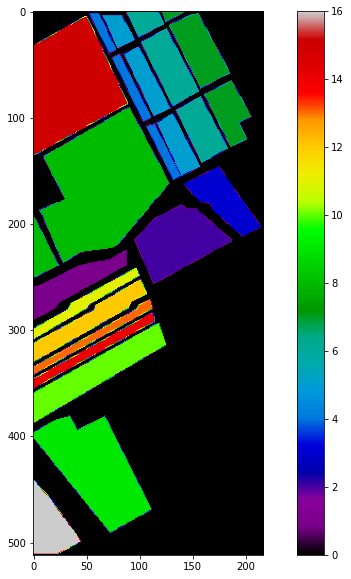

In [129]:
plt.figure(figsize=(12, 10))
plt.imshow(gt, cmap='nipy_spectral')
plt.colorbar()
print('Fig. Ground Truth:')
plt.show()

### Scale and Split Data

In [130]:
t_df = df[df['class']!=0]                   #delete class 0

X = t_df.drop(['class'], axis=1)            #x: data 
y = to_categorical(t_df['class'])           #y: target 

X_scaled = minmax_scale(X, axis = 0);       #MinMax scale

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,                  #split 70/30 %
                                                    stratify=y, test_size=0.30) 

print(f"X: {X_scaled.shape}\nX_train: {X_train.shape}\nX_test: {X_test.shape}\n")
print(f"y: {y.shape}\ny_train: {y_train.shape}\ny_test: {y_test.shape}")

X: (54129, 204)
X_train: (37890, 204)
X_test: (16239, 204)

y: (54129, 17)
y_train: (37890, 17)
y_test: (16239, 17)


### Build CNN

In [131]:
in_shape = X_train[1].shape[0]
out_classes = y_train.shape[1]

X_train = X_train.reshape(-1, 204, 1)           #input CNN reshape 
X_test = X_test.reshape(-1, 204, 1)

#### Sequential 1-D CNN Model

In [132]:
model = Sequential(name = 'Salinas_CNN')

model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu', input_shape =(in_shape,1), name = 'Conv_1'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Conv_2'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Conv_3'))

model.add(MaxPooling1D(pool_size = 2, name = 'MP_1'))
model.add(Dropout(0.4, name = 'DO_1'))

model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Conv_4'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Conv_5'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Conv_6'))

model.add(MaxPooling1D(pool_size = 2, name = 'MP_2'))
model.add(Dropout(0.4, name = 'DO_2'))

model.add(Flatten(name = 'FL'))

model.add(Dense(25, activation='relu', name = 'DL'))

model.add(Dense(out_classes, activation='softmax', name = 'OL'))


model.summary()

Model: "Salinas_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv1D)              (None, 202, 64)           256       
_________________________________________________________________
Conv_2 (Conv1D)              (None, 200, 64)           12352     
_________________________________________________________________
Conv_3 (Conv1D)              (None, 198, 64)           12352     
_________________________________________________________________
MP_1 (MaxPooling1D)          (None, 99, 64)            0         
_________________________________________________________________
DO_1 (Dropout)               (None, 99, 64)            0         
_________________________________________________________________
Conv_4 (Conv1D)              (None, 97, 32)            6176      
_________________________________________________________________
Conv_5 (Conv1D)              (None, 95, 32)            

#### Callbacks

In [133]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 10,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Salinas_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True)

#### Train

In [134]:
hist = model.fit(X_train, y_train, 
                 epochs = 100, batch_size = 256 , 
                 validation_data = (X_test, y_test), 
                 callbacks=[early_stop,checkpoint])

Epoch 1/100
149/149 [==============================] - 17s 110ms/step - loss: 1.4331 - accuracy: 0.5130 - val_loss: 0.7148 - val_accuracy: 0.7105
Epoch 2/100
149/149 [==============================] - 20s 136ms/step - loss: 0.5916 - accuracy: 0.7579 - val_loss: 0.4064 - val_accuracy: 0.8422
Epoch 3/100
149/149 [==============================] - 20s 137ms/step - loss: 0.4533 - accuracy: 0.8175 - val_loss: 0.4426 - val_accuracy: 0.8114
Epoch 4/100
149/149 [==============================] - 20s 134ms/step - loss: 0.4084 - accuracy: 0.8324 - val_loss: 0.3343 - val_accuracy: 0.8686
Epoch 5/100
149/149 [==============================] - 19s 129ms/step - loss: 0.3746 - accuracy: 0.8471 - val_loss: 0.3384 - val_accuracy: 0.8480
Epoch 6/100
149/149 [==============================] - 18s 121ms/step - loss: 0.3610 - accuracy: 0.8513 - val_loss: 0.3942 - val_accuracy: 0.8003
Epoch 7/100
149/149 [==============================] - 18s 118ms/step - loss: 0.3460 - accuracy: 0.8559 - val_loss: 0.2781 -

#### Training Charts

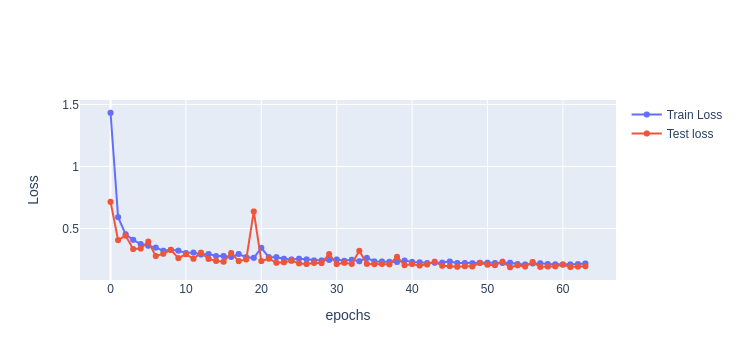

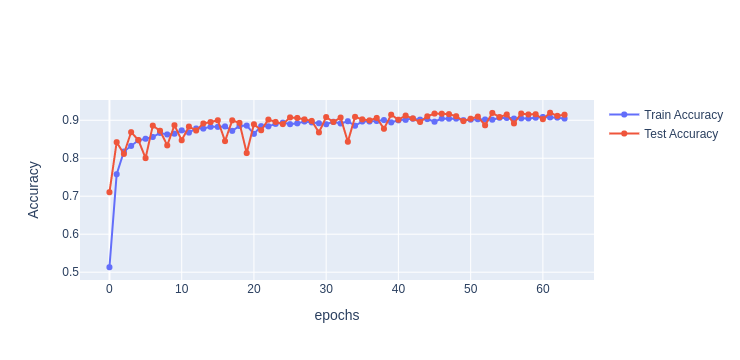

In [152]:
#hist = pd.DataFrame(data= hist.history)

fig1 = go.Figure()
fig1.update_layout( xaxis_title="epochs", yaxis_title="Loss")
fig1.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))
fig1.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))
fig1.show()

fig2 = go.Figure()
fig2.update_layout( xaxis_title="epochs", yaxis_title="Accuracy")
fig2.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))

fig2.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))
fig2.show()

### Evaluate model

In [154]:
model = load_model("Salinas_Model.h5")
loss, acc = model.evaluate(X_test, y_test)

508/508 [==============================] - 2s 3ms/step - loss: 0.1876 - accuracy: 0.9192


#### Classification Report

In [155]:
y_pred = np.argmax(model.predict(X_test), axis=1)
classes =['1. Brocoli_green_weeds_1', 
          '2. Brocoli_green_weeds_2',
          '3. Fallow',
          '4. Fallow_rough_plow',
          '5. Fallow_smooth',
          '6. Stubble',
          '7. Celery',
          '8. Grapes_untrained',
          '9. Soil_vinyard_develop',
          '10. Corn_senesced_green_weeds',
          '11. Lettuce_romaine_4wk',
          '12. Lettuce_romaine_5wk',
          '13. Lettuce_romaine_6wk',
          '14. Lettuce_romaine_7wk',
          '15. Vinyard_untrained',
          '16. Vinyard_vertical_trellis']

print(classification_report(y_pred, np.argmax(y_test, 1),target_names = classes))

                               precision    recall  f1-score   support

     1. Brocoli_green_weeds_1       0.99      1.00      0.99       597
     2. Brocoli_green_weeds_2       1.00      0.99      1.00      1126
                    3. Fallow       1.00      0.97      0.98       612
         4. Fallow_rough_plow       1.00      1.00      1.00       420
             5. Fallow_smooth       1.00      0.99      0.99       804
                   6. Stubble       1.00      1.00      1.00      1189
                    7. Celery       1.00      1.00      1.00      1071
          8. Grapes_untrained       0.86      0.80      0.83      3635
      9. Soil_vinyard_develop       1.00      0.99      0.99      1879
10. Corn_senesced_green_weeds       0.94      0.97      0.95       954
      11. Lettuce_romaine_4wk       0.97      0.98      0.97       314
      12. Lettuce_romaine_5wk       1.00      0.98      0.99       590
      13. Lettuce_romaine_6wk       0.99      0.98      0.98       276
     

#### Confusion Matrix

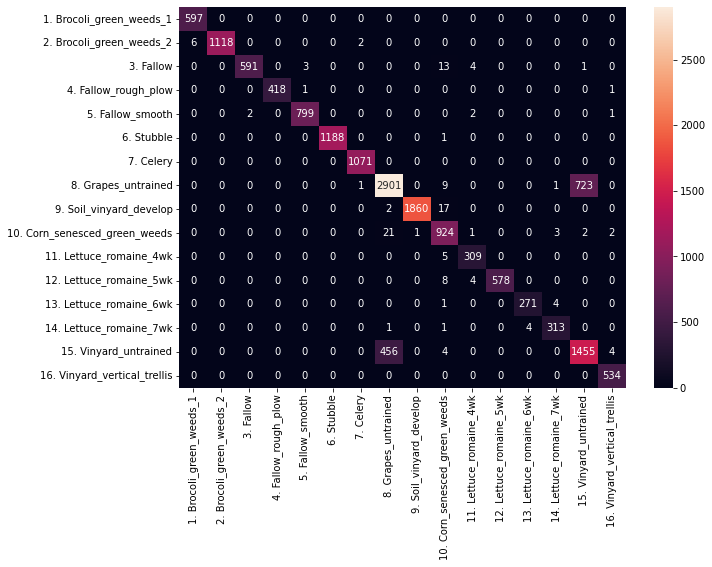

In [156]:
plt.figure(figsize = (10,7))

cm = confusion_matrix(np.add(y_pred, 1), np.add(np.argmax(y_test, 1), 1))
df_cm = pd.DataFrame(cm, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()